# CatBoostRegression Year column embedding    
    1. Year column embedding code to preserve time series properties.
    2. stock별 시계열패턴을 모델이 학습할수 있도록 작성된 코드.

In [1]:
import pandas as pd
from catboost import CatBoostRegressor

# CatBoost 다중 타겟: loss_function='MultiRMSE' 사용 (y shape: [n_samples, n_targets])
model = CatBoostRegressor(
    iterations=800,
    max_depth=8,
    learning_rate=0.06,
    loss_function='MultiRMSE',  # 다중 회귀 손실
    eval_metric='MultiRMSE',
    task_type='GPU',   # GPU 사용
    devices='0',
    boosting_type='Plain',
    random_seed=42,
    early_stopping_rounds=80,
    verbose=100
)
model

In [2]:
# Set target_columns
target_columns = ['CETR', 'GETR', 'TSTA', 'TSDA']

In [3]:
# Load CSV file
df = pd.read_csv('../data/KoTaP_Dataset.csv')
df.shape

(12653, 65)

In [4]:
# Set categorical_cols
categorical_cols = ['name', 'stock', 'KOSPI', 'big4', 'LOSS', 'ind']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print(df.dtypes)

name        category
stock       category
year           int64
KOSPI       category
fnd_year       int64
              ...   
A_CETR       float64
A_GETR3      float64
A_CETR3      float64
A_GETR5      float64
A_CETR5      float64
Length: 65, dtype: object


In [5]:
# Time-series aware encoding & global cutoff split (2011~2023 train, 2024 test)
import numpy as np

# ---- CONFIG ----
STRICT_LAG = True  # True: 이전 해(year-1)가 있는 행만 학습/평가에 사용

# 2. Lag 특징 생성 (1-step) - 이미 존재하는 lag 컬럼은 재생성하지 않음
# 제외 컬럼 정의
exclude_for_lag = set(['name', 'stock', 'year'] + target_columns)

# 이미 존재하는 lag 소스 컬럼 탐지

for c in df.columns:
    if c.startswith('lag1_'):  # 새 패턴: lag1_<col>
        exclude_for_lag.add(c[len('lag1_'):])
        exclude_for_lag.add(c)  # 원본 lag 컬럼명도 추가
    elif c.startswith('lag_'):  # 기존 패턴: lag_<col> (lag__<col> 포함)
        exclude_for_lag.add(c[len('lag_'):])
        exclude_for_lag.add(c)  # 원본 lag 컬럼명도 추가
    else:
        if c.endswith('_lag1') or ('_lag' in c and c.rsplit('_lag', 1)[-1].isdigit()):
            base = c.rsplit('_lag', 1)[0]
            exclude_for_lag.add(base)

# 수치형 후보
num_cols_for_lag = [c for c in df.columns if c not in exclude_for_lag and df[c].dtype.kind in ['i','u','f']]
# 범주형 컬럼도 lag 제외 대상에 추가
exclude_for_lag.update(categorical_cols)

# dtype이 category 또는 object인 컬럼도 추가로 제외
cat_cols_detected = df.select_dtypes(include=['category', 'object']).columns.tolist()
exclude_for_lag.update(cat_cols_detected)

exclude_for_lag.update(target_columns)  # 타겟 컬럼도 제외
print("exclude_for_lag 요소 수:", len(exclude_for_lag))
exclude_for_lag

exclude_for_lag 요소 수: 27


{'CETR',
 'GETR',
 'KOSPI',
 'LOSS',
 'TSDA',
 'TSTA',
 'asset',
 'big4',
 'c_asset',
 'c_liab',
 'equit',
 'ind',
 'lag1_ni',
 'lag_asset',
 'lag_c_asset',
 'lag_c_liab',
 'lag_equit',
 'lag_liab',
 'lag_sales',
 'lag_total',
 'liab',
 'name',
 'ni',
 'sales',
 'stock',
 'total',
 'year'}

In [6]:
# 생성 대상 선정
lag_create_targets = [col for col in num_cols_for_lag if col not in exclude_for_lag]
print("lag생성 column 대상 수:", len(lag_create_targets))
lag_create_targets

lag생성 column 대상 수: 38


['fnd_year',
 'fiscal',
 'forn',
 'own',
 'inv',
 'cogs',
 'dep',
 'tax',
 'rec',
 'ocf',
 'cash',
 'tan',
 'land',
 'cip',
 'intan',
 'pti',
 'SIZE',
 'LEV',
 'CUR',
 'GRW',
 'ROA',
 'ROE',
 'CFO',
 'PPE',
 'AGE',
 'INVREC',
 'MB',
 'TQ',
 'GETR3',
 'CETR3',
 'GETR5',
 'CETR5',
 'A_GETR',
 'A_CETR',
 'A_GETR3',
 'A_CETR3',
 'A_GETR5',
 'A_CETR5']

In [7]:
df.shape
df

,name,stock,year,KOSPI,fnd_year,fiscal,ind,big4,forn,own,...,GETR5,CETR5,TSTA,TSDA,A_GETR,A_CETR,A_GETR3,A_CETR3,A_GETR5,A_CETR5
0,동화약품,20,2013,1,1897,12,21,1,0.0613,0.3114,...,0.294414,0.266121,-0.071863,-0.088363,-0.236479,0.748503,0.058765,-0.096756,0.034497,-0.019779
1,동화약품,20,2014,1,1897,12,21,1,0.0502,0.3151,...,0.233461,0.418783,-0.001226,-0.014614,-0.150710,0.748503,0.500993,0.733432,-0.026455,0.132883
2,동화약품,20,2015,1,1897,12,21,1,0.0749,0.3235,...,0.231593,0.528209,0.072994,0.056283,-0.171420,-0.024525,-0.195255,0.733432,-0.028324,0.242310
3,동화약품,20,2016,1,1897,12,21,1,0.0746,0.3229,...,0.306044,0.325968,0.106756,0.107570,0.026917,-0.194237,-0.174602,0.327249,0.046128,0.040069
4,동화약품,20,2017,1,1897,12,21,1,0.1186,0.3240,...,0.250474,0.216419,-0.061506,0.008744,0.042469,-0.157749,-0.014648,-0.184860,-0.009442,-0.069481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12648,잉글우드랩,950140,2023,0,2015,12,20,0,0.1248,0.4408,...,0.174191,0.211668,-0.317902,-0.362904,-0.122071,0.080095,-0.064306,0.002523,0.001916,0.012473
12649,잉글우드랩,950140,2024,0,2015,12,20,0,0.1358,0.4408,...,0.114758,0.256242,-0.358287,-0.384294,-0.123269,0.292943,-0.129741,0.004858,-0.091928,0.027420
12650,고스트스튜디오,950190,2022,0,2016,12,58,1,0.1374,0.4427,...,0.176417,0.172354,-0.109588,-0.137899,-0.055951,-0.122758,-0.039628,0.121765,-0.064150,-0.092251
12651,고스트스튜디오,950190,2023,0,2016,12,58,1,0.1445,0.5158,...,0.180101,0.204584,-0.225762,-0.237668,-0.034687,-0.052817,-0.041439,-0.021230,-0.060466,-0.060022


In [8]:
# 생성
for col in lag_create_targets:
    df[f'lag__{col}'] = df.groupby('stock', observed=True)[col].shift(1)

print(f"[Lag] lag생성 제외(활용된 col, lag col 그자체 등) 컬럼 수: {len(exclude_for_lag)} | 새로 생성: {len(lag_create_targets)}")
if lag_create_targets:
    print("[Lag] 새로 생성된 예시:", lag_create_targets[:10])

[Lag] lag생성 제외(활용된 col, lag col 그자체 등) 컬럼 수: 27 | 새로 생성: 38
[Lag] 새로 생성된 예시: ['fnd_year', 'fiscal', 'forn', 'own', 'inv', 'cogs', 'dep', 'tax', 'rec', 'ocf']


In [9]:
df.shape
df

,name,stock,year,KOSPI,fnd_year,fiscal,ind,big4,forn,own,...,lag__GETR3,lag__CETR3,lag__GETR5,lag__CETR5,lag__A_GETR,lag__A_CETR,lag__A_GETR3,lag__A_CETR3,lag__A_GETR5,lag__A_CETR5
0,동화약품,20,2013,1,1897,12,21,1,0.0613,0.3114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,동화약품,20,2014,1,1897,12,21,1,0.0502,0.3151,...,0.308501,0.169812,0.294414,0.266121,-0.236479,0.748503,0.058765,-0.096756,0.034497,-0.019779
2,동화약품,20,2015,1,1897,12,21,1,0.0749,0.3235,...,0.750728,1.000000,0.233461,0.418783,-0.150710,0.748503,0.500993,0.733432,-0.026455,0.132883
3,동화약품,20,2016,1,1897,12,21,1,0.0746,0.3229,...,0.054480,1.000000,0.231593,0.528209,-0.171420,-0.024525,-0.195255,0.733432,-0.028324,0.242310
4,동화약품,20,2017,1,1897,12,21,1,0.1186,0.3240,...,0.075133,0.593817,0.306044,0.325968,0.026917,-0.194237,-0.174602,0.327249,0.046128,0.040069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12648,잉글우드랩,950140,2023,0,2015,12,20,0,0.1248,0.4408,...,0.177105,0.251967,0.266716,0.239756,-0.104659,-0.049056,0.001014,0.081624,0.094442,0.040561
12649,잉글우드랩,950140,2024,0,2015,12,20,0,0.1358,0.4408,...,0.111786,0.172867,0.174191,0.211668,-0.122071,0.080095,-0.064306,0.002523,0.001916,0.012473
12650,고스트스튜디오,950190,2022,0,2016,12,58,1,0.1374,0.4427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12651,고스트스튜디오,950190,2023,0,2016,12,58,1,0.1445,0.5158,...,0.178244,0.350704,0.176417,0.172354,-0.055951,-0.122758,-0.039628,0.121765,-0.064150,-0.092251


In [10]:
# 2. Year 기반 전역/종목별 트렌드 & 주기 인코딩
year_min = df['year'].min()
year_max = df['year'].max()

# 전역 정규화 (0~1)
df['year_norm_global'] = (df['year'] - year_min) / (year_max - year_min)

# 종목별 시작 기준 index (0부터 증가)
df['year_index_stock'] = df.groupby('stock', observed=True)['year'].rank(method='dense').astype(int) - 1
# 종목별 상대적 진행도 (0~1)
df['year_norm_stock'] = df['year_index_stock'] / df.groupby('stock', observed=True)['year_index_stock'].transform('max')

# 주기성 (사이클) 표현: 한 전체 구간(2011~2024)을 하나의 2π 주기로 가정
angle = 2 * np.pi * df['year_norm_global']
df['year_sin'] = np.sin(angle)
df['year_cos'] = np.cos(angle)

# 2-1. 실제 연속 연도 여부 계산 (gap 정보)
df['year_gap'] = df.groupby('stock', observed=True)['year'].diff()
df['has_prev_year'] = df['year_gap'].eq(1)  # True/False

df.shape
df

,name,stock,year,KOSPI,fnd_year,fiscal,ind,big4,forn,own,...,lag__A_CETR3,lag__A_GETR5,lag__A_CETR5,year_norm_global,year_index_stock,year_norm_stock,year_sin,year_cos,year_gap,has_prev_year
0,동화약품,20,2013,1,1897,12,21,1,0.0613,0.3114,...,NaN,NaN,NaN,0.153846,0,0.000000,8.229839e-01,0.568065,NaN,False
1,동화약품,20,2014,1,1897,12,21,1,0.0502,0.3151,...,-0.096756,0.034497,-0.019779,0.230769,1,0.090909,9.927089e-01,0.120537,1.0,True
2,동화약품,20,2015,1,1897,12,21,1,0.0749,0.3235,...,0.733432,-0.026455,0.132883,0.307692,2,0.181818,9.350162e-01,-0.354605,1.0,True
3,동화약품,20,2016,1,1897,12,21,1,0.0746,0.3229,...,0.733432,-0.028324,0.242310,0.384615,3,0.272727,6.631227e-01,-0.748511,1.0,True
4,동화약품,20,2017,1,1897,12,21,1,0.1186,0.3240,...,0.327249,0.046128,0.040069,0.461538,4,0.363636,2.393157e-01,-0.970942,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12648,잉글우드랩,950140,2023,0,2015,12,20,0,0.1248,0.4408,...,0.081624,0.094442,0.040561,0.923077,2,0.666667,-4.647232e-01,0.885456,1.0,True
12649,잉글우드랩,950140,2024,0,2015,12,20,0,0.1358,0.4408,...,0.002523,0.001916,0.012473,1.000000,3,1.000000,-2.449294e-16,1.000000,1.0,True
12650,고스트스튜디오,950190,2022,0,2016,12,58,1,0.1374,0.4427,...,NaN,NaN,NaN,0.846154,0,0.000000,-8.229839e-01,0.568065,NaN,False
12651,고스트스튜디오,950190,2023,0,2016,12,58,1,0.1445,0.5158,...,0.121765,-0.064150,-0.092251,0.923077,1,0.500000,-4.647232e-01,0.885456,1.0,True


In [11]:
# Train/test 데이터셋 분리
# 3. 전역 컷오프 기반 연도 분리 (Train: <=2023, Test: 2024)
CUTOFF_TEST_YEAR = 2024
train_mask_full = df['year'] < CUTOFF_TEST_YEAR
full_test_mask = df['year'] == CUTOFF_TEST_YEAR

train_df = df[train_mask_full].copy()
test_df = df[full_test_mask].copy()

In [12]:
train_df.shape, test_df.shape

((11567, 110), (1086, 110))

In [13]:
# include unseen stocks too by using the union of train and test stocks
seen_stocks = set(train_df['stock'].unique()) | set(test_df['stock'].unique())

# 4. 2024 테스트셋 STRICT_LAG 적용: 직전 연도가 실제로 존재(연속)하는 행만 유지
# removed_train 과 removed_test는 '얼마나 줄었는지' 파악하는 로그용 변수.
if STRICT_LAG:
    before_train_rows = len(train_df)
    before_test_rows = len(test_df)
    train_df = train_df[train_df['has_prev_year']].copy()
    test_df = test_df[test_df['has_prev_year']].copy()
    removed_train = before_train_rows - len(train_df)
    removed_test = before_test_rows - len(test_df)
else:
    removed_train = 0
    removed_test = 0

train_df.shape, test_df.shape

((9095, 110), (929, 110))

In [14]:
# debug
cols = train_df.columns.tolist()
print(f"Columns ({len(cols)}):")
for c in cols:
    print(c)

Columns (110):
name
stock
year
KOSPI
fnd_year
fiscal
ind
big4
forn
own
c_asset
inv
asset
sales
cogs
dep
tax
rec
ni
ocf
cash
tan
land
cip
intan
liab
c_liab
pti
total
equit
lag_asset
lag_liab
lag_equit
lag_sales
lag_total
lag1_ni
lag_c_asset
lag_c_liab
SIZE
LEV
CUR
GRW
ROA
ROE
CFO
PPE
AGE
INVREC
MB
TQ
LOSS
GETR
CETR
GETR3
CETR3
GETR5
CETR5
TSTA
TSDA
A_GETR
A_CETR
A_GETR3
A_CETR3
A_GETR5
A_CETR5
lag__fnd_year
lag__fiscal
lag__forn
lag__own
lag__inv
lag__cogs
lag__dep
lag__tax
lag__rec
lag__ocf
lag__cash
lag__tan
lag__land
lag__cip
lag__intan
lag__pti
lag__SIZE
lag__LEV
lag__CUR
lag__GRW
lag__ROA
lag__ROE
lag__CFO
lag__PPE
lag__AGE
lag__INVREC
lag__MB
lag__TQ
lag__GETR3
lag__CETR3
lag__GETR5
lag__CETR5
lag__A_GETR
lag__A_CETR
lag__A_GETR3
lag__A_CETR3
lag__A_GETR5
lag__A_CETR5
year_norm_global
year_index_stock
year_norm_stock
year_sin
year_cos
year_gap
has_prev_year


In [15]:
# 5. Feature / Target 분리
feature_drop = ['name'] + target_columns
X_train = train_df.drop(columns=feature_drop)
X_test_2024 = test_df.drop(columns=feature_drop)
X_train.shape, X_test_2024.shape

((9095, 105), (929, 105))

In [16]:
# 5. debug
cols = X_train.columns.tolist()
print(f"Columns ({len(cols)}):")
for c in cols:
    print(c)

Columns (105):
stock
year
KOSPI
fnd_year
fiscal
ind
big4
forn
own
c_asset
inv
asset
sales
cogs
dep
tax
rec
ni
ocf
cash
tan
land
cip
intan
liab
c_liab
pti
total
equit
lag_asset
lag_liab
lag_equit
lag_sales
lag_total
lag1_ni
lag_c_asset
lag_c_liab
SIZE
LEV
CUR
GRW
ROA
ROE
CFO
PPE
AGE
INVREC
MB
TQ
LOSS
GETR3
CETR3
GETR5
CETR5
A_GETR
A_CETR
A_GETR3
A_CETR3
A_GETR5
A_CETR5
lag__fnd_year
lag__fiscal
lag__forn
lag__own
lag__inv
lag__cogs
lag__dep
lag__tax
lag__rec
lag__ocf
lag__cash
lag__tan
lag__land
lag__cip
lag__intan
lag__pti
lag__SIZE
lag__LEV
lag__CUR
lag__GRW
lag__ROA
lag__ROE
lag__CFO
lag__PPE
lag__AGE
lag__INVREC
lag__MB
lag__TQ
lag__GETR3
lag__CETR3
lag__GETR5
lag__CETR5
lag__A_GETR
lag__A_CETR
lag__A_GETR3
lag__A_CETR3
lag__A_GETR5
lag__A_CETR5
year_norm_global
year_index_stock
year_norm_stock
year_sin
year_cos
year_gap
has_prev_year


In [17]:
# y == label.
y_train = train_df[target_columns]
y_test_2024 = test_df[target_columns]
y_train.shape, y_test_2024.shape

((9095, 4), (929, 4))

In [18]:
# 6. Lag 결측 처리: 새 네이밍(lag__*) 포함하여 처리. 기존 'lag_' col은 결측 없음.
lag_cols = [c for c in X_train.columns if c.startswith('lag__') or c.endswith('_lag1')]
if lag_cols:
    lag_medians = X_train[lag_cols].median()
    X_train[lag_cols] = X_train[lag_cols].fillna(lag_medians)
    X_test_2024[lag_cols] = X_test_2024[lag_cols].fillna(lag_medians)

X_train.shape, X_test_2024.shape

((9095, 105), (929, 105))

In [ ]:
# 7. Summary

print(f"Train years: {int(train_df['year'].min())}-{int(train_df['year'].max())} | Test year: {CUTOFF_TEST_YEAR}")
print(f"Cutoff and Seen stocks count in train_df: {len(seen_stocks)}")
print("STRICT_LAG:", STRICT_LAG, f"| Removed train rows: {removed_train} | Removed test rows: {removed_test}")
print("Shapes -> Train:", X_train.shape, "2024 Test:", X_test_2024.shape)
print("Lag feature count:", len(lag_cols))

Train years: 2012-2023 | Test year: 2024
Cutoff and Seen stocks count in train_df: 1754
STRICT_LAG: True | Removed train rows: 2472 | Removed test rows: 157
Shapes -> Train: (9095, 105) 2024 Test: (929, 105)
Lag feature count: 38


In [20]:
# debug
X_train.to_csv('X_train.csv', index=True)
print('Saved: X_train.csv', X_train.shape)

Saved: X_train.csv (9095, 105)


In [21]:
from catboost import Pool

# 8. CatBoost Pool 생성 (category dtype 유지된 컬럼 식별)
cat_feature_names = [c for c in X_train.columns if str(train_df[c].dtype) == 'category']
cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_feature_names]

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_feature_indices)
test_pool = Pool(data=X_test_2024, label=y_test_2024, cat_features=cat_feature_indices)

In [ ]:
# 7. 모델 학습 & 평가 (CatBoost Pool 사용)
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
model.fit(train_pool)

pred_seen = model.predict(test_pool)
print('[Seen Stocks 2024] R2:', r2_score(y_test_2024, pred_seen),
      'MAE:', mean_absolute_error(y_test_2024, pred_seen),
      'RMSE:', root_mean_squared_error(y_test_2024, pred_seen))

0:	learn: 0.4386140	total: 45.4ms	remaining: 36.3s
100:	learn: 0.1113375	total: 1.18s	remaining: 8.17s
200:	learn: 0.0842081	total: 2.29s	remaining: 6.84s
300:	learn: 0.0684093	total: 3.43s	remaining: 5.69s
400:	learn: 0.0576087	total: 4.59s	remaining: 4.57s
500:	learn: 0.0495046	total: 5.76s	remaining: 3.44s
600:	learn: 0.0431692	total: 6.93s	remaining: 2.29s
700:	learn: 0.0379008	total: 8.09s	remaining: 1.14s
799:	learn: 0.0335245	total: 9.24s	remaining: 0us
[Seen Stocks 2024] R2: 0.9516951159616803 MAE: 0.026956842713645207 RMSE: 0.04954115753753126


In [23]:
# 타겟별 상세
print('\nPer-target metrics:')
for i, col in enumerate(target_columns):
    r2_i = r2_score(y_test_2024[col], pred_seen[:, i])
    mae_i = mean_absolute_error(y_test_2024[col], pred_seen[:, i])
    rmse_i = root_mean_squared_error(y_test_2024[col], pred_seen[:, i])
    print(f"  {col}: R2={r2_i:.4f} MAE={mae_i:.4f} RMSE={rmse_i:.4f}")

# importance
fi = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('\nTop 25 Feature Importances:')
print(fi.head(25))


Per-target metrics:
  CETR: R2=0.9895 MAE=0.0161 RMSE=0.0227
  GETR: R2=0.9726 MAE=0.0152 RMSE=0.0220
  TSTA: R2=0.9239 MAE=0.0373 RMSE=0.0753
  TSDA: R2=0.9207 MAE=0.0392 RMSE=0.0782

Top 25 Feature Importances:
year                31.450288
A_CETR              17.312160
lag_asset            9.181667
A_GETR               7.878596
year_sin             4.769504
lag__fnd_year        4.096160
ocf                  3.094820
SIZE                 2.969032
asset                2.890462
CFO                  1.838190
AGE                  0.825264
ind                  0.808821
ROA                  0.770026
lag__SIZE            0.712086
equit                0.696454
year_norm_global     0.518159
ROE                  0.511810
lag_equit            0.454946
GETR5                0.435480
lag_liab             0.361939
lag__own             0.351227
stock                0.328310
sales                0.326354
KOSPI                0.283006
land                 0.266145
dtype: float64


            R2       MAE      RMSE
CETR  0.989521  0.016092  0.022657
GETR  0.972649  0.015250  0.022021
TSTA  0.923870  0.037252  0.075320
TSDA  0.920741  0.039233  0.078167


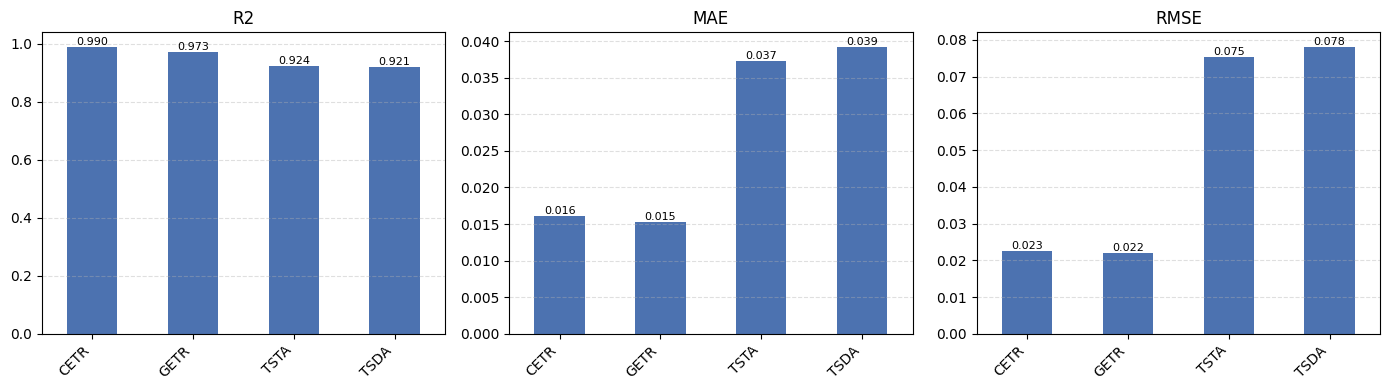

In [24]:
import matplotlib.pyplot as plt

# 타겟별 성능지표 계산
metrics = {'R2': [], 'MAE': [], 'RMSE': []}
for i, col in enumerate(target_columns):
    y_true = y_test_2024[col]
    y_pred = pred_seen[:, i]
    metrics['R2'].append(r2_score(y_true, y_pred))
    metrics['MAE'].append(mean_absolute_error(y_true, y_pred))
    metrics['RMSE'].append(root_mean_squared_error(y_true, y_pred))

metrics_df = pd.DataFrame(metrics, index=target_columns)
print(metrics_df)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, metric in zip(axes, metrics_df.columns):
    axes_idx = metrics_df[metric].plot(kind='bar', ax=ax, color='#4C72B0')
    ax.set_title(metric)
    ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(f'{val:.3f}', (p.get_x() + p.get_width()/2, val),
                    ha='center', va='bottom', fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

In [26]:
# 8. 결과 저장 (Seen test)
import numpy as np
results_df = pd.DataFrame(
    data = np.hstack([y_test_2024.values, pred_seen]),
    columns = [f'actual_{col}' for col in y_test_2024.columns] + [f'pred_{col}' for col in y_test_2024.columns],
    index = y_test_2024.index,
)
results_df.to_csv('actual_vs_predicted_seen_2024_catboost.csv', index=True)
print('Saved: actual_vs_predicted_seen_2024_catboost.csv')

# Per-target metrics 저장
metric_rows = []
for i, col in enumerate(target_columns):
    metric_rows.append({
        'target': col,
        'R2': r2_score(y_test_2024[col], pred_seen[:, i]),
        'MAE': mean_absolute_error(y_test_2024[col], pred_seen[:, i]),
        'RMSE': root_mean_squared_error(y_test_2024[col], pred_seen[:, i])
    })
metrics_df = pd.DataFrame(metric_rows)
metrics_df.to_csv('CatBoost_metrics_seen_2024.csv', index=False)
print('Saved: CatBoost_metrics_seen_2024.csv')

Saved: actual_vs_predicted_seen_2024_catboost.csv
Saved: CatBoost_metrics_seen_2024.csv


## Reference site
    지표 및 점수
    https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation
    https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

    [Training_Parameters] 
    1. https://catboost.ai/docs/en/references/training-parameters/
    2. https://catboost.ai/docs/en/concepts/loss-functions-multiregression
    3. https://catboost.ai/docs/en/concepts/python-reference_catboostregressor